<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import" data-toc-modified-id="Data-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Backtesting" data-toc-modified-id="Backtesting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Backtesting</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys


import pandas as pd
import numpy as np
import pyfolio as pf
import alphalens as al

import quantitative_scoring as qs
from scipy.stats import ttest_1samp

pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline
%load_ext autoreload

%autoreload 2

/Users/Thomas/anaconda/lib/python3.5/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)
/Users/Thomas/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data import

In [ ]:
full_data = pd.read_csv('data/all_stocks_merged.csv', parse_dates=['Date'])

In [3]:
full_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,ticker
0,0,1999-11-18,30.713,33.754,27.002,29.702,66277506,A
1,1,1999-11-19,28.986,29.027,26.872,27.257,16142920,A
2,2,1999-11-22,27.886,29.702,27.044,29.702,6970266,A
3,3,1999-11-23,28.688,29.446,27.002,27.002,6332082,A
4,4,1999-11-24,27.083,28.309,27.002,27.717,5132147,A


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887665 entries, 0 to 14887664
Data columns (total 8 columns):
Unnamed: 0    int64
Date          datetime64[ns]
Open          float64
High          float64
Low           float64
Close         float64
Volume        int64
ticker        object
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 908.7+ MB


## Data cleaning

In [5]:
bloomberg_tickers = pd.read_excel('data/universe.xlsx').query('region == "USA" & security_ccy == "USD"')['ticker']
bloomberg_tickers = bloomberg_tickers.apply(lambda x: x.split(' ')[0]).values

In [6]:
eqs_short_ls = full_data.where(full_data['ticker'].isin(list(bloomberg_tickers)))

In [7]:
full_data = None

In [8]:
test = eqs_short_ls.query('"2014-12-31" <= Date <= "2017-11-10"')

In [27]:
prices = test.pivot(index='Date', columns='ticker', values='Close')

## Backtesting

In [9]:
spy = pd.read_table('data/ETFs/spy.us.txt', sep=',', parse_dates=True, usecols=['Date', 'Close'])
spy['Date'] = pd.to_datetime(spy['Date'])
spy.set_index('Date', inplace=True)
spy_rets = spy['Close'].pct_change().shift(-1)
spy_rets.name = 'SPY'

In [10]:
strat = qs.DailyScoreStrategy(bars=test, n_positions=30, how='long only')

In [25]:
signals = strat.generate_signals()

/Users/Thomas/udacity/AlgoTrading/quantitative_scoring.py:62: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  U = max([df.get_value(dates[i], 'Close') - df.get_value(dates[i-1], 'Close'), 0])
/Users/Thomas/udacity/AlgoTrading/quantitative_scoring.py:63: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  D = max([df.get_value(dates[i-1], 'Close') - df.get_value(dates[i], 'Close'), 0])


In [29]:
portfolio = qs.DailyPortfolio(bars=prices, signals=signals)

In [30]:
portfolio.generate_weights()

In [32]:
returns, positions, transactions = portfolio.backtest_portfolio()

/Users/Thomas/anaconda/lib/python3.5/site-packages/pyfolio/tears.py:200: UserWarning: The latest version of pyfolio requires users to supply benchmark returns. Your current tearsheets will not include plots and analyses that require a benchmark. In the future, please pass benchmark_rets, or pass None to silence this warning.
  warnings.warn(BENCHMARK_RETS_WARNING)


Start date,2015-10-14
End date,2017-11-10
Total months,25
,Backtest
Annual return,6.3%
Cumulative returns,13.5%
Annual volatility,19.3%
Sharpe ratio,0.41
Calmar ratio,0.41
Stability,0.59
Max drawdown,-15.4%


/Users/Thomas/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.43,2015-11-05,2016-01-19,2016-04-28,126
1,14.92,2016-08-17,2016-11-03,2016-11-22,70
2,11.06,2016-12-07,2017-04-12,NaT,NaN
3,9.96,2016-04-28,2016-05-17,2016-07-05,49
4,4.04,2016-07-11,2016-07-22,2016-08-04,19


/Users/Thomas/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Thomas/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


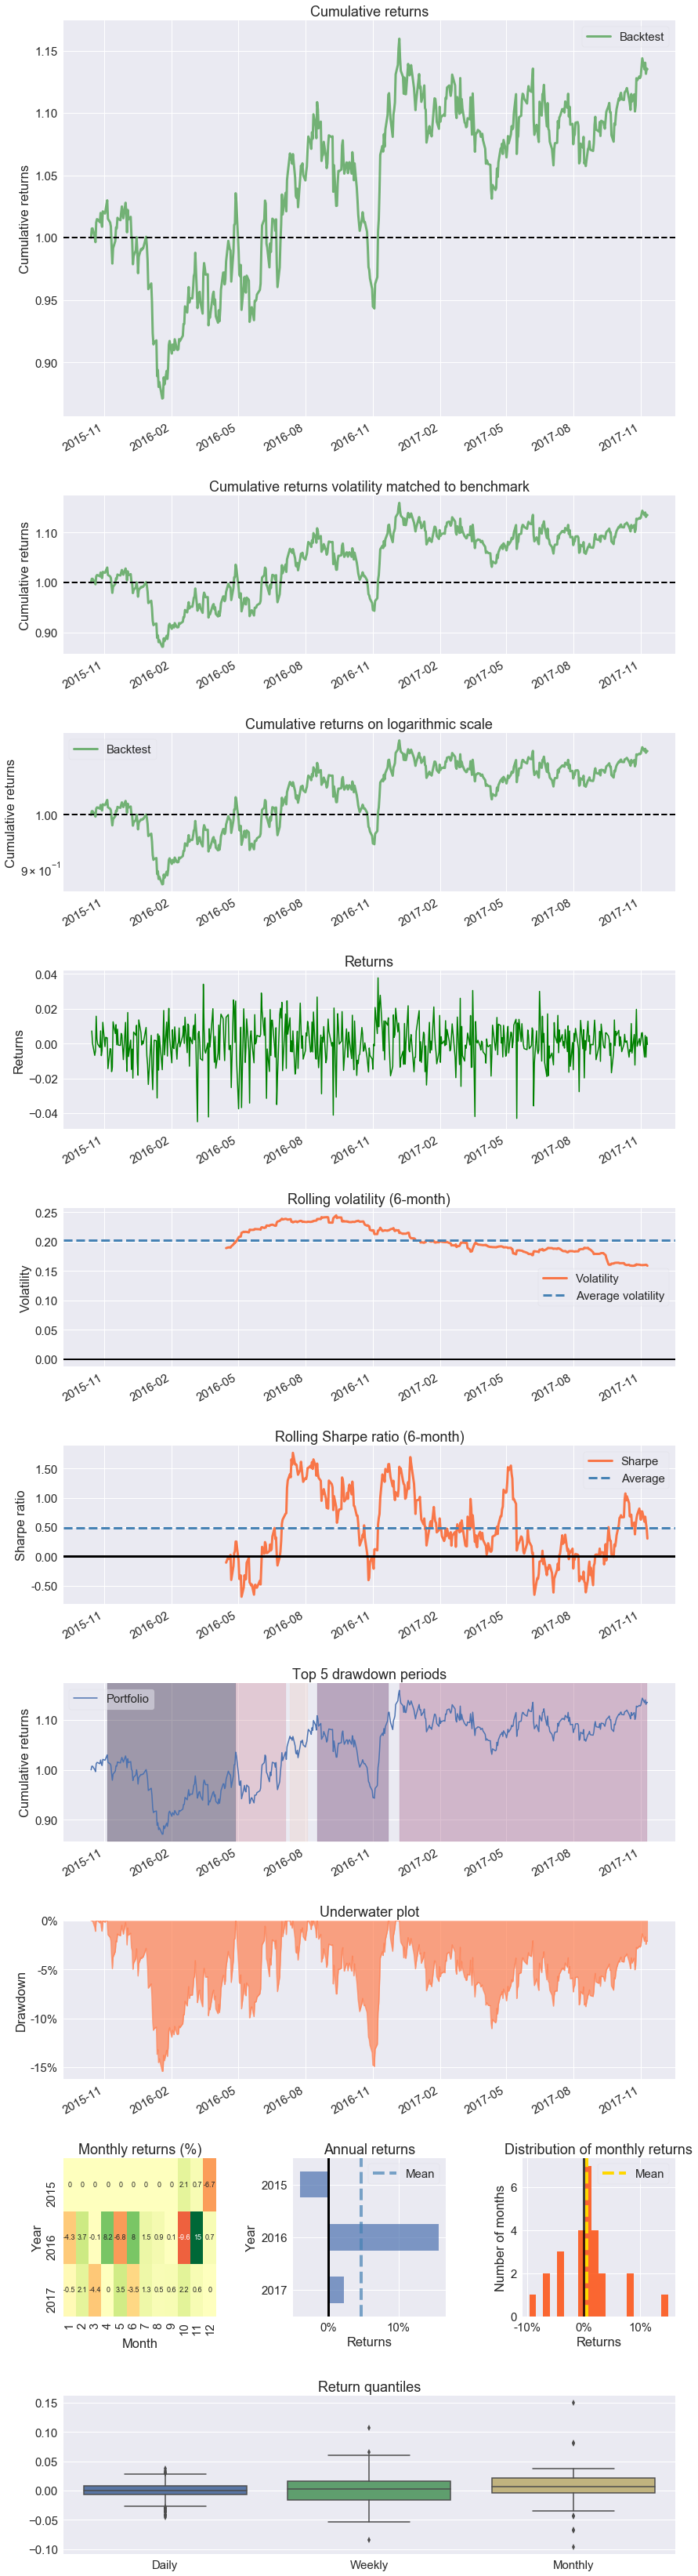

Stress Events,mean,min,max
New Normal,0.03%,-4.49%,3.78%


AttributeError: 'NoneType' object has no attribute 'copy'

In [34]:
pf.create_full_tear_sheet(returns['returns'], positions=positions, transactions=transactions)